<a href="https://colab.research.google.com/github/hydrus3109/PRIMES_AIprivacy/blob/main/ECNN_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from typing import List, Tuple, Any, Union

import math
import numpy as np
import torch
from torch.nn import AdaptiveAvgPool2d
import torch.nn.functional as F
!pip install e2cnn
from e2cnn import gspaces
from e2cnn import nn
from e2cnn.nn import init
from e2cnn.nn import GeometricTensor
from e2cnn.nn import FieldType
from argparse import ArgumentParser
from e2cnn.nn import EquivariantModule
from e2cnn.gspaces import *

from argparse import ArgumentParser
# change batch norm to group norm
class VGG11(torch.nn.Module):

    def __init__(self, dropout_rate, num_classes=10,
                 N: int = 4,
                 r: int = 0,
                 f: bool = False,
                 deltaorth: bool = False,
                 fixparams: bool = True,
                 ):

        r"""

        Build equivariant VGG-11.

        The parameter ``N`` controls rotation equivariance and the parameter ``f`` reflection equivariance.

        More precisely, ``N`` is the number of discrete rotations the model is initially equivariant to.
        ``N = 1`` means the model is only reflection equivariant from the beginning.

        ``f`` is a boolean flag specifying whether the model should be reflection equivariant or not.
        If it is ``False``, the model is not reflection equivariant.

        ``r`` is the restriction level:

        - ``0``: no restriction. The model is equivariant to ``N`` rotations from the input to the output
        - ``1``: restriction before the last block. The model is equivariant to ``N`` rotations before the last block
               (i.e. in the first 2 blocks). Then it is restricted to ``N/2`` rotations until the output.

        - ``2``: restriction after the first block. The model is equivariant to ``N`` rotations in the first block.
               Then it is restricted to ``N/2`` rotations until the output (i.e. in the last 3 blocks).

        - ``3``: restriction after the first and the second block. The model is equivariant to ``N`` rotations in the first
               block. It is restricted to ``N/2`` rotations before the second block and to ``1`` rotations before the last
               block.

        NOTICE: if restriction to ``N/2`` is performed, ``N`` needs to be even!

        """

        super(VGG11, self).__init__()
        self.nStages = [16, 32, 64, 64, 128, 128, 128, 128, 1024]

        # number of discrete rotations to be equivariant to
        self._N = N

        # if the model is [F]lip equivariant
        self._f = f
        if self._f:
            if self._N != 1:
                self.gspace = gspaces.FlipRot2dOnR2(N)
            else:
                self.gspace = gspaces.Flip2dOnR2()
        else:
            if self._N != 1:
                self.gspace = gspaces.Rot2dOnR2(N)
            else:
                self.gspace = gspaces.TrivialOnR2()

        self.input_type = nn.FieldType(self.gspace, 3*[self.gspace.trivial_repr])

        #ConvBlock-1 16x3x3
        in_type = self.input_type
        out_type = nn.FieldType(self.gspace, self.nStages[0]*[self.gspace.regular_repr])
        self.block1 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 3, padding = 1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ELU(out_type, inplace=True)
        )

        #MaxPool-1 2x2
        self.pool1 = nn.SequentialModule(
            nn.PointwiseMaxPool(out_type, kernel_size  = 2, stride = 2)
        )

        #ConvBlock-2 32x3x3
        in_type = self.block1.out_type
        out_type = nn.FieldType(self.gspace, self.nStages[1]*[self.gspace.regular_repr])
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 3, padding = 1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ELU(out_type, inplace=True)
        )

        #MaxPool-2 2x2
        self.pool2 = nn.SequentialModule(
            nn.PointwiseMaxPool(out_type, kernel_size = 2, stride = 2)
        )

        #ConvBlock-3 64x3x3
        in_type = self.block2.out_type
        out_type = nn.FieldType(self.gspace, self.nStages[2]*[self.gspace.regular_repr])
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 3, padding = 1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ELU(out_type, inplace=True)
        )

        #ConvBlock-4 64x3x3
        in_type = self.block3.out_type
        out_type = nn.FieldType(self.gspace, self.nStages[3]*[self.gspace.regular_repr])
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 3, padding = 1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ELU(out_type, inplace=True)
        )

        #MaxPool-3 2x2
        self.pool3 = nn.SequentialModule(
            nn.PointwiseMaxPool(out_type, kernel_size  = 2, stride = 2)
        )

        #ConvBlock-5 128x3x3
        in_type = self.block4.out_type
        out_type = nn.FieldType(self.gspace, self.nStages[4]*[self.gspace.regular_repr])
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 3, padding = 1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ELU(out_type, inplace=True)
        )

        #ConvBlock-6 128x3x3
        in_type = self.block5.out_type
        out_type = nn.FieldType(self.gspace, self.nStages[5]*[self.gspace.regular_repr])
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 3, padding = 1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ELU(out_type, inplace=True)
        )

        #MaxPool-4 2x2
        self.pool4 = nn.SequentialModule(
            nn.PointwiseMaxPool(out_type, kernel_size  = 2, stride = 2)
        )

        #ConvBlock-7 128x3x3
        in_type = self.block6.out_type
        out_type = nn.FieldType(self.gspace, self.nStages[6]*[self.gspace.regular_repr])
        self.block7 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 3, padding = 1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ELU(out_type, inplace=True)
        )

        #ConvBlock-8 128x3x3
        in_type = self.block7.out_type
        out_type = nn.FieldType(self.gspace, self.nStages[7]*[self.gspace.regular_repr])
        self.block8 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 3, padding = 1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ELU(out_type, inplace=True)
        )

        self.gpool = nn.GroupPooling(out_type)
        c = self.gpool.out_type.size
        self.pool5=AdaptiveAvgPool2d(1)

        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(c, self.nStages[8]),
            torch.nn.GroupNorm(2,self.nStages[8]),
            torch.nn.ELU(inplace=True),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(self.nStages[8], num_classes),
        )


    def forward(self, input: torch.Tensor):
        x = nn.GeometricTensor(input, self.input_type)
        out = self.block1(x)
        out = self.pool1(out)

        out = self.block2(out)
        out = self.pool2(out)

        out = self.block3(out)
        out = self.block4(out)
        out = self.pool3(out)

        out = self.block5(out)
        out = self.block6(out)
        out = self.pool4(out)

        out = self.block7(out)
        out = self.block8(out)

        out = self.gpool(out)

        # extract the tensor from the GeometricTensor to use the common Pytorch operations
        out = out.tensor
        gpool_out = out

        out = self.pool5(out)
        out = self.fully_net(out.reshape(out.shape[0], -1))

        return out


if __name__ == "__main__":


    m = VGG11(0.3, N=4, f=True, r=0, num_classes=10)
    m.eval()

    # 3 random 64x64 RGB images (i.e. with 3 channel)
    x = torch.randn(1, 3, 32, 32)

    # the images flipped along the vertical axis
    x_fv = x.flip(dims=[3])
    # the images flipped along the horizontal axis
    x_fh = x.flip(dims=[2])
    # the images rotated by 90 degrees
    x90 = x.rot90(1, (2, 3))
    # the images flipped along the horizontal axis and rotated by 90 degrees
    x90_fh = x.flip(dims=[2]).rot90(1, (2, 3))

    # feed all inputs to the model
    y= m(x)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


TypeError: ignored

In [ ]:
from torch.cuda.random import device_count
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
import torch.optim as optim
import torchvision.transforms as transforms
import torch
import torchvision
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./', train=True,download=True,transform = transform)
train = list(range(0, 1000,1))
valid = list(range(1000, 2000,1))
test = list(range(0,1000,1))

trainset_1 = torch.utils.data.Subset(trainset, train)
trainloader_1 = torch.utils.data.DataLoader(trainset_1, shuffle=True, num_workers=4,batch_size = 20)
validset = torch.utils.data.Subset(trainset, valid)
validloader = torch.utils.data.DataLoader(validset, shuffle=True, num_workers=4,batch_size = 20)
testset = torchvision.datasets.CIFAR10(root='./data', train = False, download=True, transform=transform)
testset_1 = torch.utils.data.Subset(testset, train)
testloader_1 = torch.utils.data.DataLoader(testset_1, shuffle=True, num_workers=4,batch_size = 20)
print(len(trainset_1))
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

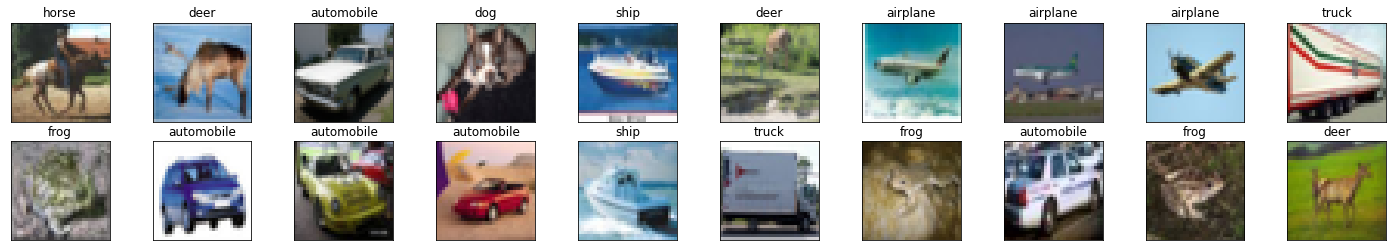

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
# obtain one batch of training images
dataiter = iter(trainloader_1)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
m = VGG11(0.3, N=4, f=True, r=0, num_classes=10)
m.eval()
criterion = torch.nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(m.parameters(), lr=.001)
train_losslist = []
# number of epochs to train the model
n_epochs = [*range(20)] # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in n_epochs:

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    m.train()
    for data, target in trainloader_1:
        # move tensors to GPU if CUDA is available
       # if train_on_gpu:
           # data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = m(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    m.eval()
    for data, target in validloader:
        # move tensors to GPU if CUDA is available
        #if train_on_gpu:
            #data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = m(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(trainloader_1.dataset)
    valid_loss = valid_loss/len(validloader.dataset)

    train_losslist.append(train_loss)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(m
        .state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

KeyboardInterrupt: ignored

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

m.eval()
# iterate over test data
for data, target in testloader_1:
    # move tensors to GPU if CUDA is available
    #data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = m(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(10):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader_1.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.735922

Test Accuracy of airplane: 37% (19/51)
Test Accuracy of automobile: 48% (20/41)
Test Accuracy of  bird: 37% (20/54)
Test Accuracy of   cat: 23% (13/56)
Test Accuracy of  deer: 18% ( 9/49)
Test Accuracy of   dog: 21% ( 9/41)
Test Accuracy of  frog: 58% (30/51)
Test Accuracy of horse: 51% (25/49)
Test Accuracy of  ship: 36% (18/50)
Test Accuracy of truck: 48% (28/58)

Test Accuracy (Overall): 38% (191/500)


In [ ]:
from numpy.linalg import norm
params1 = []
norms1 = []
for param in m.parameters():
   # print(param)
    temp = param.detach().numpy()
    norms1.append(norm(temp))
    print(np.shape(temp))
    params1.append(temp)
print(np.shape(params1))
print(norm(norms1))

(288,)
(16,)
(16,)
(24576,)
(32,)
(32,)
(98304,)
(64,)
(64,)
(196608,)
(64,)
(64,)
(393216,)
(128,)
(128,)
(786432,)
(128,)
(128,)
(786432,)
(128,)
(128,)
(786432,)
(128,)
(128,)
(1024, 128)
(1024,)
(1024,)
(1024,)
(10, 1024)
(10,)
(30,)
78.62837


In [ ]:

from numpy.linalg import norm
params2 = []
norms2 = []
for param in m.parameters():
   # print(param)
    temp = param.detach().numpy()
    norms2.append(norm(temp))
    print(np.shape(temp))
    params2.append(temp)
print(np.shape(params2))
print(norm(norms2))

(288,)
(16,)
(16,)
(24576,)
(32,)
(32,)
(98304,)
(64,)
(64,)
(196608,)
(64,)
(64,)
(393216,)
(128,)
(128,)
(786432,)
(128,)
(128,)
(786432,)
(128,)
(128,)
(786432,)
(128,)
(128,)
(1024, 128)
(1024,)
(1024,)
(1024,)
(10, 1024)
(10,)
(30,)
78.559166


In [ ]:
results = []
for x in range(24):
  temp = params1[x]-params2[x]
  results.append(norm(temp))

print(norm(results))

90.82565
